# LegacyHalos SersicFitting

This notebook demonstrates how we fit the 1D surface brightness profiles using various parametric (e.g., Sersic) models, using one galaxy as a toy example.

### Imports, paths, and other preliminaries.

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from legacyhalos import io
from legacyhalos.util import ellipse_sbprofile
from legacyhalos.qa import display_ellipse_sbprofile

In [3]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [4]:
pixscale = 0.262
band = ('g', 'r', 'z')
refband = 'r'

### Read the sample

In [5]:
sample = io.read_sample(istart=0, iend=1)

Read 1 galaxies


In [6]:
objid, objdir = io.get_objid(sample)
ellipsefit = io.read_ellipsefit(objid, objdir)
redshift = sample.z

### Surface brightness profile

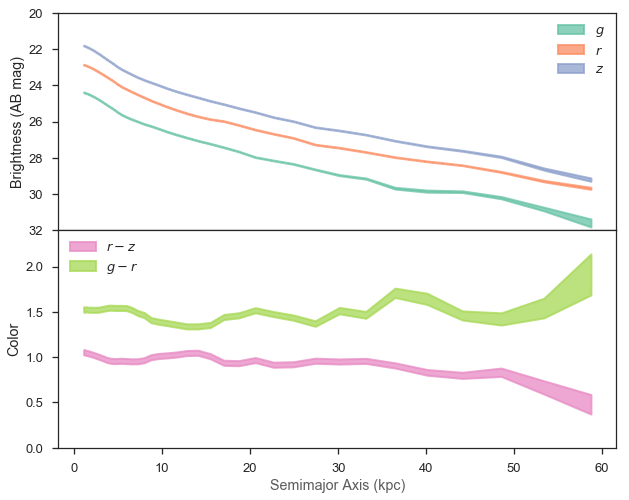

In [7]:
display_ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                          redshift=redshift, pixscale=pixscale)

In [8]:
sbprofile = ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                              redshift=redshift, pixscale=pixscale)
sbprofile.keys()

dict_keys(['smaunit', 'sma', 'g', 'g_err', 'mu_g', 'r', 'r_err', 'mu_r', 'z', 'z_err', 'mu_z', 'gr', 'rz', 'gr_err', 'rz_err'])

### Playing around below here

In [9]:
stop

NameError: name 'stop' is not defined

In [ ]:
stop

In [ ]:
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
smascale = 1
filt = 'r'
good = (ellipsefit[filt].stop_code < 4)
bad = ~good
fig, ax1 = plt.subplots()
ax1.fill_between(ellipsefit[filt].sma[good] * smascale, 
                 ellipsefit[filt].eps[good]-ellipsefit[filt].ellip_err[good],
                 ellipsefit[filt].eps[good]+ellipsefit[filt].ellip_err[good],
                 edgecolor='k', lw=2)

#ax1.errorbar(ellipsefit[filt].sma[good] * smascale,
#             ellipsefit[filt].eps[good],
#             ellipsefit[filt].ellip_err[good], marker='s', linestyle='none',
#             capsize=10, capthick=2, 
#             markersize=10)#, color=color[filt])
ax1.scatter(ellipsefit[filt].sma[bad] * smascale,
             ellipsefit[filt].eps[bad], marker='s', s=40, edgecolor='k', lw=2, alpha=0.75)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())